In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
repository = DataRepository()

Connected to MySQL Server version  5.7.39-42-log


In [3]:
dut_os = "Win32NT"
profiler_name = "IntelPowerGadget"

dut_name = "Surface4Pro"
test_case_name = "DiningPhilosophers"

min_temp = 0
max_temp = 200

min_battery = 1
max_battery = 100

between = 0
duration = 2

version = 4

language = "CSharp"
env = "PROD"

limit = 200

In [4]:
energy_profiler = EnergyProfiler(profiler_name, repository)

energy_profiler.id, energy_profiler.energy_profiler_name


(1, 'IntelPowerGadget')

In [5]:
dut = Dut(dut_name, dut_os, repository)

dut.id, dut.dut_name, dut.dut_os

(6, 'Surface4Pro', 'Win32NT')

In [6]:
config = Configuration(min_temp, max_temp, min_battery, max_battery, duration, between, version, repository, env)

config.id, config.min_battery, config.max_battery, config.min_temp, config.max_temp, config.version, config.env, config.duration, config.between

(13, 1, 100, 0, 200, 4, 'PROD', 2, 0)

In [7]:
test_case = TestCase(test_case_name, repository)
test_case.id, test_case.test_case_name

(2, 'DiningPhilosophers')

In [8]:
experiment = Experiment(config.id, dut.id, test_case.id, language, repository, 200)
len(experiment.experiments), experiment.config_id, experiment.dut_id, experiment.language, experiment.test_case_id, experiment.count


(36, 13, 6, 'CSharp', 2, 200)

In [9]:
temp_experiment = experiment.experiments[0]

temp_experiment.end_time, temp_experiment.start_time, temp_experiment.runs, temp_experiment.iteration, temp_experiment.duration

(datetime.datetime(2022, 10, 24, 14, 15, 26, 58899),
 datetime.datetime(2022, 10, 24, 14, 13, 9, 345762),
 269,
 5,
 121121)

In [12]:
[x.value for x in temp_experiment.start_temperature.data], [x.value for x in temp_experiment.stop_temperature.data]

([Decimal('39'), Decimal('39')], [Decimal('37'), Decimal('44')])

In [13]:
[x.value for x in temp_experiment.start_battery.data], [x.value for x in temp_experiment.stop_battery.data]

([Decimal('76'), Decimal('75')], [Decimal('76'), Decimal('75')])

In [10]:
durations = [x.duration / x.runs for x in experiment.experiments]
dram_avg = [x.AverageDRAMPower0InWatt for x in experiment.experiments]
gt_power_avg = [x.AverageGTPower0InWatt for x in experiment.experiments]
ai_power_avg = [x.AverageIAPower0InWatt for x in experiment.experiments]
processor_power_avg = [x.AverageProcessorPower0InWatt for x in experiment.experiments]

In [11]:
def add_avg_and_std(values, dict, name, i):
    dict[i]["avg_" + name] = sum(values) / len(values)  
    dict[i]["std_" + name] = np.std(values) 
    dict[i]["len_" + name] = len(values) 

In [12]:
def plot_for_key(values_to_plot, key, y_max):
    plt.ylim(0,y_max)
    x = [v for v in values_to_plot]
    y = [values_to_plot[v]["avg_" + key] for v in values_to_plot]
    e = [values_to_plot[v]["std_" + key] for v in values_to_plot]
    
    counts = [values_to_plot[v]["len_" + key] for v in values_to_plot]
    
    print(f"The count: {counts}")

    plt.errorbar(x, y, e, linestyle='None', marker='.')

In [13]:
groups = defaultdict(list)
values = defaultdict(dict)

for obj in experiment.experiments:
    groups[obj.iteration].append(obj)

tuples_to_plot = []

for g in groups:
    if not g in values:
        values[g] = {}
    
    durations = [x.duration / x.runs for x in groups[g]]
    dram_avg = [x.AverageDRAMPower0InWatt for x in groups[g]]
    gt_power_avg = [x.AverageGTPower0InWatt for x in groups[g]]
    ai_power_avg = [x.AverageIAPower0InWatt for x in groups[g]]
    processor_power_avg = [x.AverageProcessorPower0InWatt for x in groups[g]]
    
    add_avg_and_std(durations, values, "duration", g)
    add_avg_and_std(dram_avg, values, "dram", g)
    add_avg_and_std(gt_power_avg, values, "gt", g)
    add_avg_and_std(ai_power_avg, values, "ai", g)
    add_avg_and_std(processor_power_avg, values, "processor", g)



The count: [4, 4, 4, 4, 5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


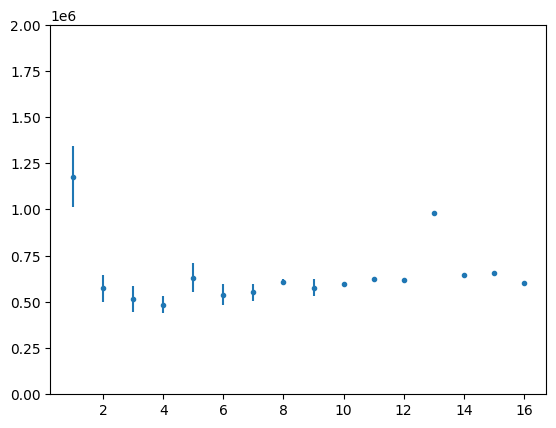

In [14]:
plot_for_key(values, "processor", 2000000)


The count: [4, 4, 4, 4, 5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


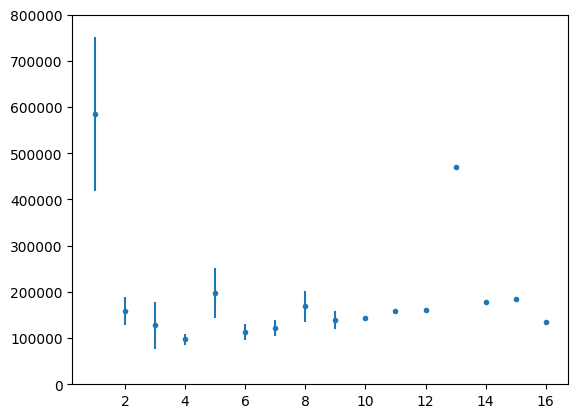

In [19]:
plot_for_key(values, "ai", 800000)


The count: [4, 4, 4, 4, 5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


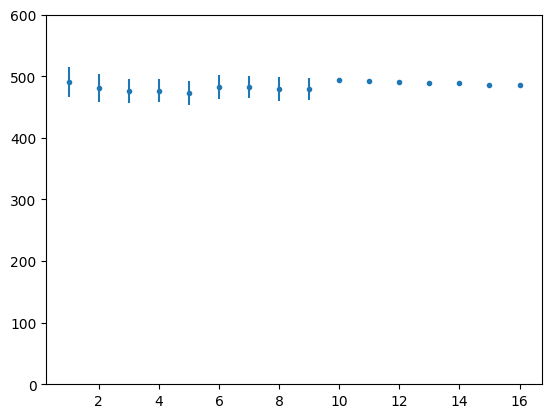

In [16]:
plot_for_key(values, "duration", 600)

The count: [4, 4, 4, 4, 5, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1]


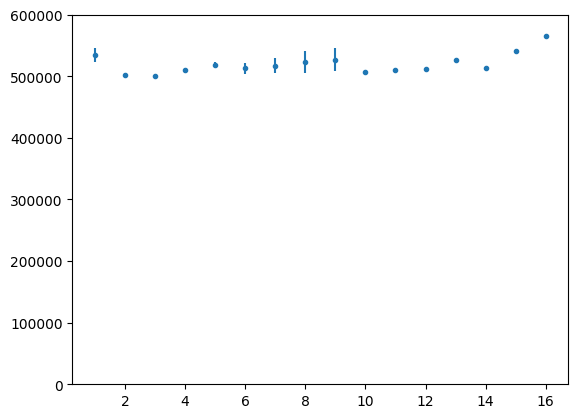

In [17]:
plot_for_key(values, "dram", 600000)

In [16]:
# [x.value for x in temp_experiment.battery.data]



0
2
4
6
8
